## The general case

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import convolve

In [3]:
import starry
lmax = 3
N = (lmax + 1) ** 2
map = starry.Map(lmax, lazy=False)
A1 = map.ops.A1.eval()


def Ij(j, gamma):
    """
    
    """
    if j == 0:
        return 0.5 * np.pi * (1 - gamma ** 2)
    else:
        return (j - 1) / (j + 2) * (1 - gamma ** 2) * Ij(j - 2, gamma)

    
def sn(n, xi, w=0.01, i=90.0):
    """
    
    """
    # This is a vector function!
    xi = np.atleast_1d(xi)
    res = np.zeros_like(xi)
    
    # Indices
    L = np.floor(np.sqrt(n))
    D = 0.5 * (n - L ** 2)
    ii = int(np.floor(L - D))
    j = int(np.floor(D))
    k = int(np.ceil(D) - np.floor(D))
    
    # x coordinate of lines of constant Doppler shift
    # (very non relativistic)
    gamma = -xi / (w * np.sin(i * np.pi / 180.0))
    
    # Integral is only nonzero when we're
    # inside the unit disk
    idx = np.abs(gamma) < 1
    
    # Solve the integral
    if (k == 0) and (j % 2 == 0):
        res[idx] = (2 * gamma[idx] ** ii * (1 - gamma[idx] ** 2) ** (0.5 * (j + 1))) / (j + 1)
    elif (k == 1) and (j % 2 == 0):
        res[idx] = gamma[idx] ** ii * Ij(j, gamma[idx])
    
    return res


def s(xi, w=0.01, i=90.0):
    """
    
    """
    res = np.zeros((N, len(xi)))
    for n in range(N):
        res[n] = sn(n, xi, w=w, i=i)
    return res


def g33(xi, w=0.01, i=90.0):
    """
    
    """
    # A1 is a sparse scipy matrix, so `*` 
    # is actually how we dot matrices!
    return (s(xi, w=w, i=i).T * A1)[:, 15]

In [4]:
def Y33(x, y):
    """
    The spherical harmonic Y_{3, 3}(x, y),
    which we will use as an example stellar
    map.
    
    """
    norm = 2.0 / np.sqrt(np.pi)
    return norm * 0.25 * np.sqrt(35 / (2 * np.pi)) * x * (x ** 2 - 3 * y ** 2)

In [5]:
def beta(x, y, w=0.01, i=90, alpha=0, cb=0):
    """
    The Doppler field for a differentially-
    rotating star with convective blueshift.
    
    """
    sini = np.sin(i * np.pi / 180)
    cosi = np.cos(i * np.pi / 180)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    return w * sini * x * (1 - alpha * (sini * y + cosi * z) ** 2) + z * cb

In [240]:
def plot(w=0.01, i=60, alpha=0.5, cb=0.):
    """
    Plot the Doppler field over the map.
    
    """
    # Grid up the star
    x = np.linspace(-1, 1, 500)
    y = np.linspace(-1, 1, 500)
    x, y = np.meshgrid(x, y)
    outside = x ** 2 + y ** 2 > 1
    x[outside] = np.nan
    y[outside] = np.nan

    # Compute the map
    M = Y33(x, y)
    
    # Compute the Doppler field
    D = -beta(x, y, w=w, i=i, alpha=alpha, cb=cb)

    # Plot it
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.imshow(M, origin="lower", extent=(-1, 1, -1, 1), cmap="plasma")
    ax.contour(D, origin="lower", colors="w", levels=10, linewidths=1, extent=(-1, 1, -1, 1))
    ax.axis('off');

In [7]:
def compute_numerical(xi, w=0.01, i=60, alpha=0.5, cb=0.3, nxy=500):
    """
    Compute g_{3,3} numerically by gridding up
    the star.
    
    """
    # Grid up the star
    x = np.linspace(-1, 1, nxy)
    y = np.linspace(-1, 1, nxy)
    x, y = np.meshgrid(x, y)    
    inside = x ** 2 + y ** 2 < 1
    x = x[inside].flatten()
    y = y[inside].flatten()
    npts = len(x)
    
    # Compute the map
    M = Y33(x, y)
    
    # Compute the Doppler field
    D = -beta(x, y, w=w, i=i, alpha=alpha, cb=cb)

    # g is just the weighted histogram
    nxi = len(xi)
    dxi = xi[1] - xi[0]
    bins = np.append(xi - 0.5 * dxi, [xi[-1] + 0.25 * dxi])
    g, _ = np.histogram(D, weights=M * nxi / npts, bins=bins)
        
    # Look into these edge effects
    g[0] = 0
    g[-1] = 0
    
    return g

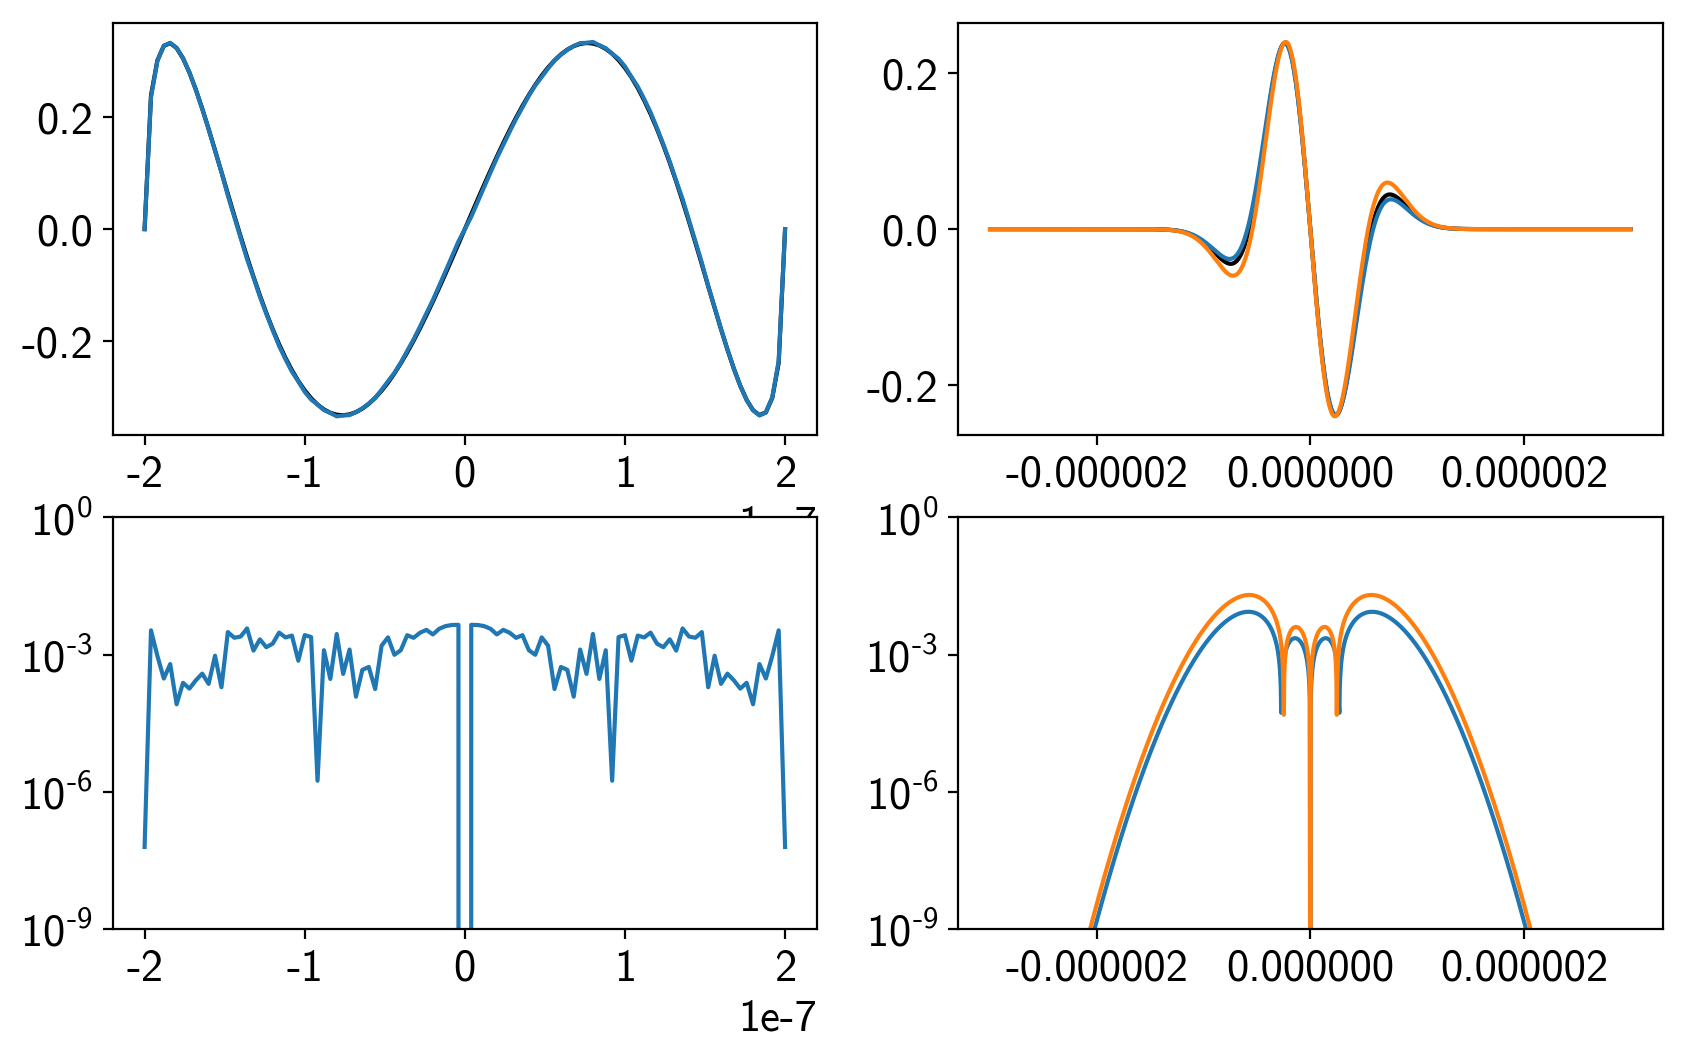

In [152]:
# Define a base spectrum
xi = np.linspace(-1e-5, 1e-5, 5001)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 3e-6
amp = 1.0
mu = 0.0
sigma = 3e-7
I0 = -amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)

# Compute the Doppler functions
w = 2e-7
nxy = 300
tau = xi[(xi >= -w) & (xi <= w)]
g_num = compute_numerical(tau, w=w, i=90.0, alpha=0.0, cb=0.0, nxy=nxy)
g_exact = g33(tau, w=w, i=90.0)
g_num_norm = np.sqrt(np.mean(g_exact ** 2) / np.mean(g_num ** 2))

# Convolve with the spectrum
S_num = convolve(I0, g_num, mode="same")
S_exact = convolve(I0, g_exact, mode="same")
S_num_norm = np.sqrt(np.mean(S_exact ** 2) / np.mean(S_num ** 2))

# Compute the brute force spectrum
x = np.linspace(-1, 1, nxy)
y = np.linspace(-1, 1, nxy)
x, y = np.meshgrid(x, y)
inside = x ** 2 + y ** 2 < 1
x = x[inside].flatten()
y = y[inside].flatten()
image = np.tile(Y33(x, y).reshape(-1, 1), len(xi))
spec = np.interp(xi + w * x.reshape(-1, 1), xi, I0)
S_brute = np.sum(image * spec, axis=0)
S_brute_norm = np.sqrt(np.mean(S_exact ** 2) / np.mean(S_brute ** 2))

# Plot them
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].plot(tau, g_exact, "k-")
ax[0, 0].plot(tau, g_num * g_num_norm, "C0-")
ax[1, 0].plot(tau, np.abs(g_num * g_num_norm - g_exact), "C0-")
ax[1, 0].set_yscale("log")
ax[1, 0].set_ylim(1e-9, 1e0)

ax[0, 1].plot(xi[obs], S_exact[obs], "k-")
ax[0, 1].plot(xi[obs], S_num[obs] * S_num_norm, "C0-")
ax[0, 1].plot(xi[obs], S_brute[obs] * S_brute_norm, "C1-")
ax[1, 1].plot(xi[obs], np.abs(S_num[obs] * S_num_norm - S_exact[obs]), "C0-")
ax[1, 1].plot(xi[obs], np.abs(S_brute[obs] * S_brute_norm - S_exact[obs]), "C1-")
ax[1, 1].set_yscale("log")
ax[1, 1].set_ylim(1e-9, 1e0);

100%|██████████| 90/90 [00:27<00:00,  1.29it/s]


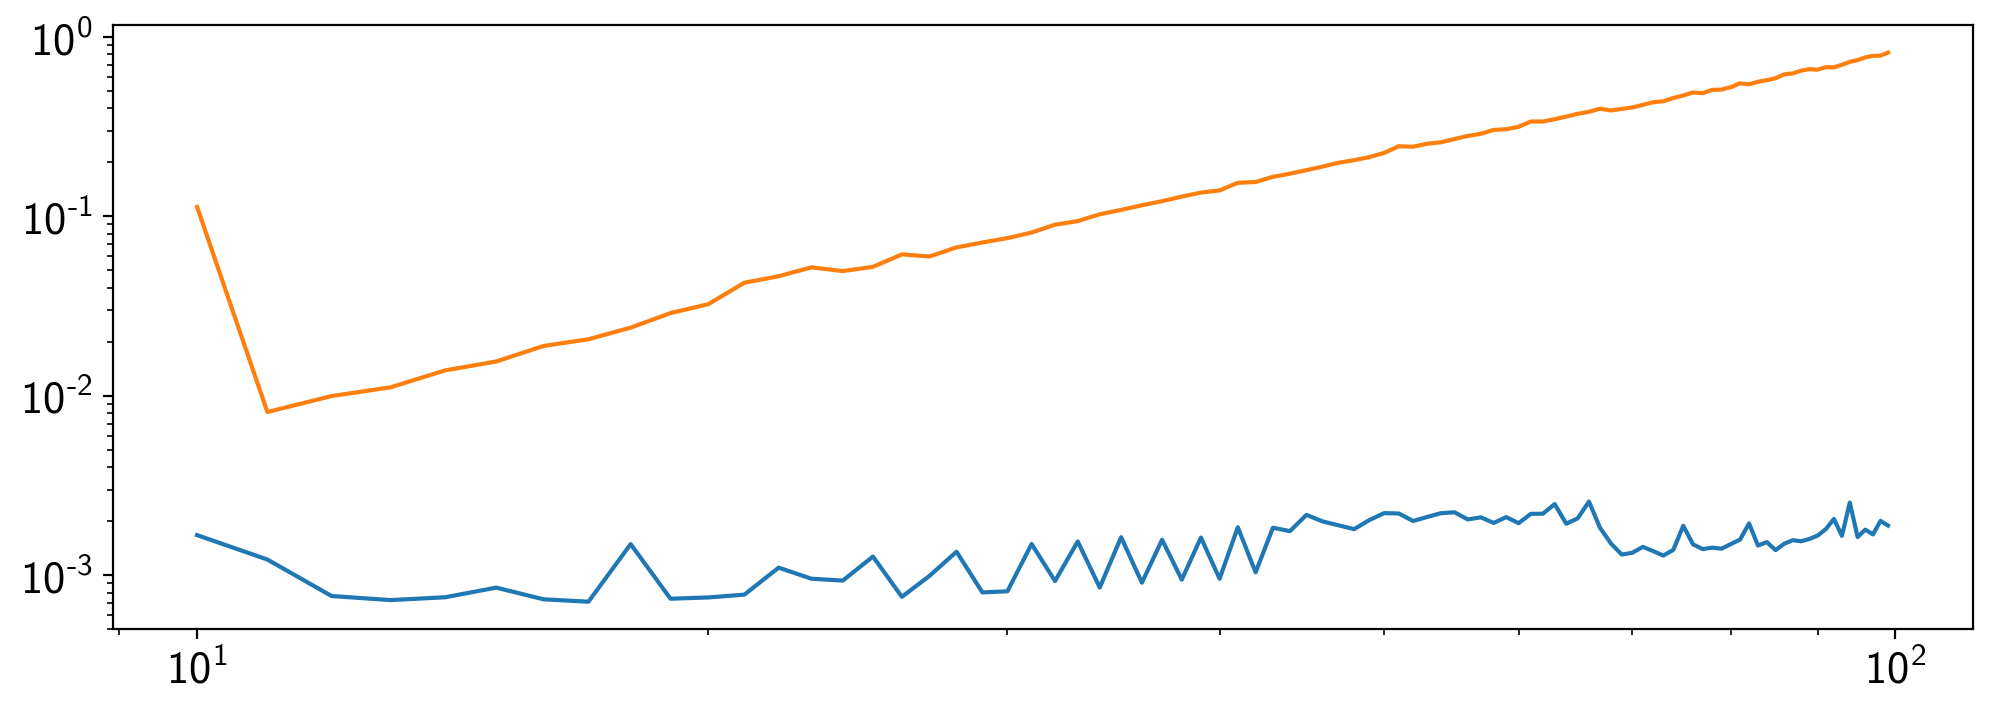

In [11]:
from tqdm import tqdm
import time

xi = np.linspace(-1e-5, 1e-5, 5001)
dxi = xi[1] - xi[0]
obs = np.abs(xi) < 3e-6
amp = 1.0
mu = 0.0
sigma = 3e-7
I0 = -amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)
w = 2e-7
tau = xi[(xi >= -w) & (xi <= w)]
g_exact = g33(tau, w=w, i=90.0)
S_exact = convolve(I0, g_exact, mode="same")

nxy_arr = np.array(np.arange(10, 100), dtype=int)
time_num = np.zeros(len(nxy_arr))
time_brute = np.zeros(len(nxy_arr))

for i, nxy in tqdm(enumerate(nxy_arr), total=len(nxy_arr)):
    
    # The grid
    x = np.linspace(-1, 1, nxy)
    y = np.linspace(-1, 1, nxy)
    x, y = np.meshgrid(x, y)
    inside = x ** 2 + y ** 2 < 1
    x = x[inside].flatten()
    y = y[inside].flatten()
    npts = len(x)
    
    # Our numerical method
    tstart = time.time()
    M = Y33(x, y)
    D = -beta(x, y, w=w, i=90, alpha=0, cb=0)
    dxi = xi[1] - xi[0]
    bins = np.append(xi - 0.5 * dxi, [xi[-1] + 0.25 * dxi])
    g, _ = np.histogram(D, weights=M * len(xi) / npts, bins=bins)
    g_num = compute_numerical(tau, w=w, i=90.0, alpha=0.0, cb=0.0, nxy=nxy)
    S_num = convolve(I0, g_num, mode="same")
    time_num[i] = time.time() - tstart
    
    # Brute force
    tstart = time.time()
    image = np.tile(Y33(x, y).reshape(-1, 1), len(xi))
    spec = np.interp(xi + w * x.reshape(-1, 1), xi, I0)
    S_brute = np.sum(image * spec, axis=0)
    time_brute[i] = time.time() - tstart
    
plt.plot(nxy_arr, time_num)
plt.plot(nxy_arr, time_brute)
plt.yscale("log")
plt.xscale("log")

## Experimenting with integration schemes

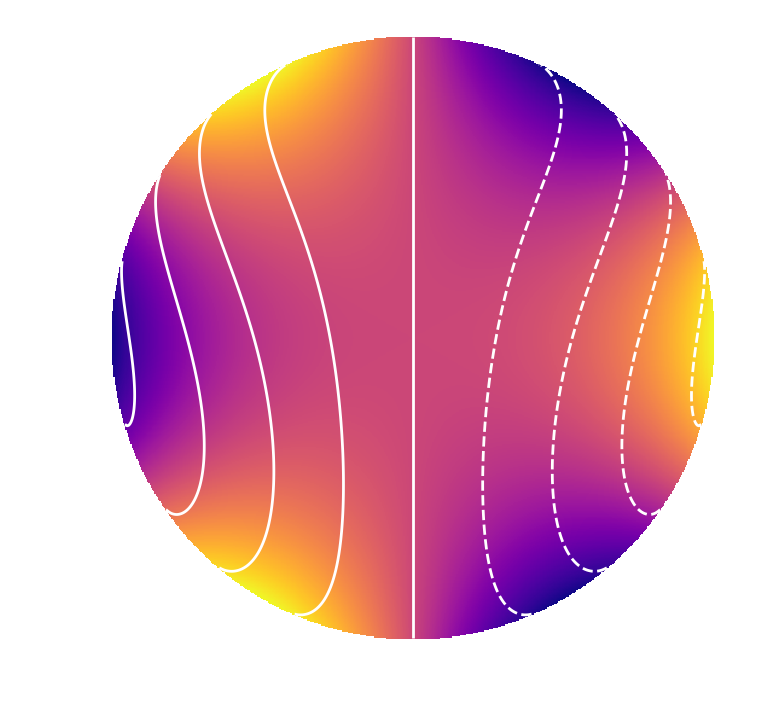

In [276]:
plot(w=0.01, i=60, alpha=0.7)

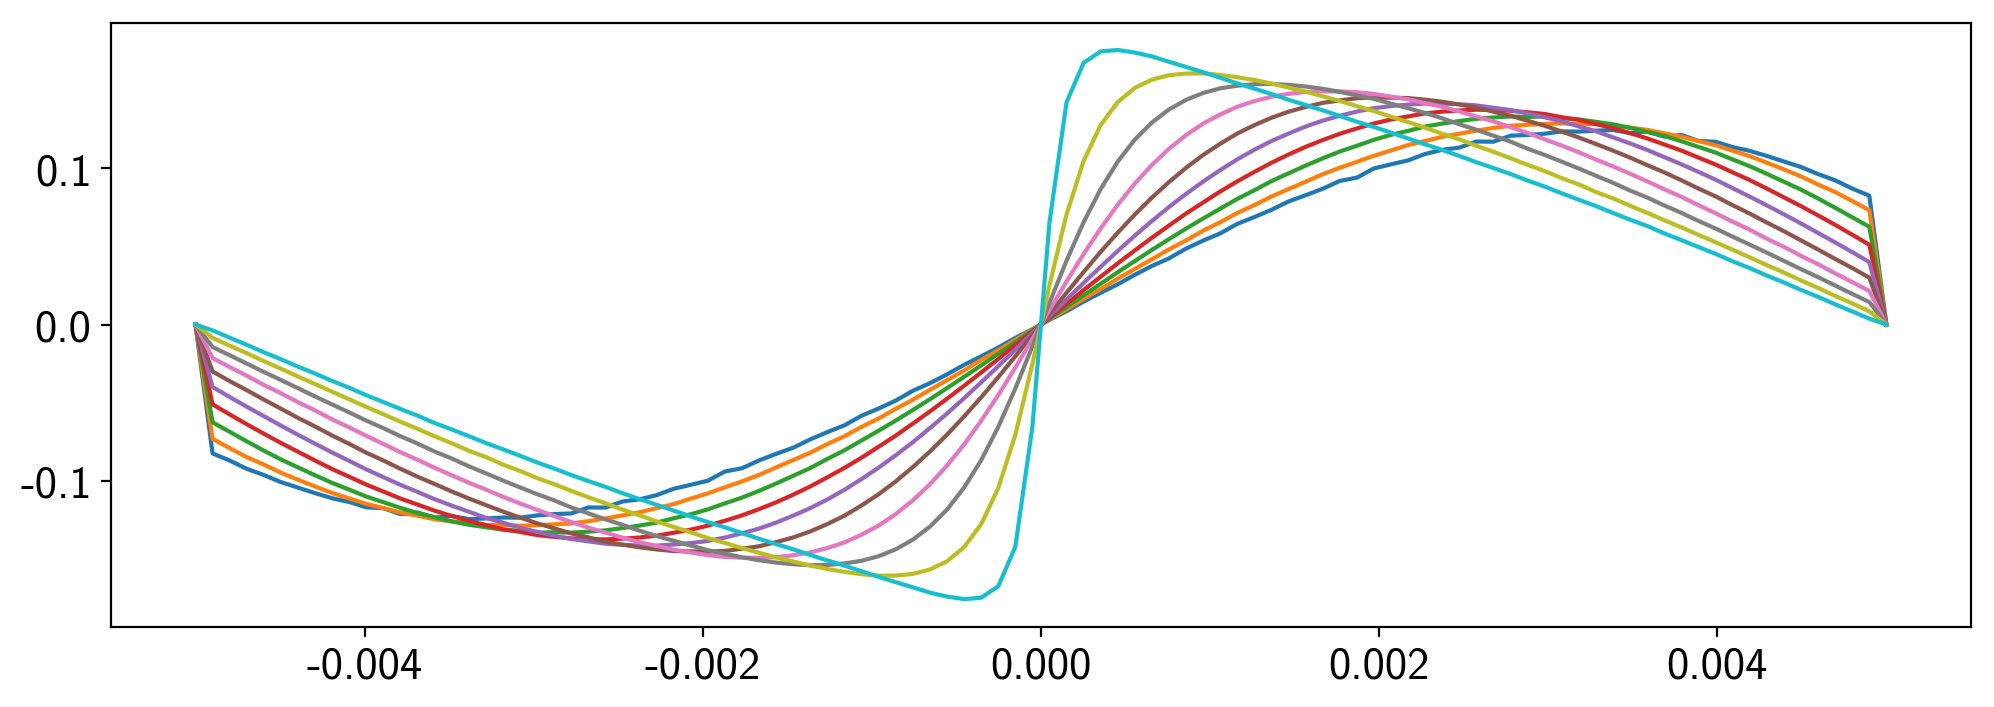

In [271]:
w = 0.01
i = 60
alpha = 0.7
cb = 0.0
nxy = 3000
tau = np.linspace(-0.005, 0.005, 100)

for alpha in np.linspace(0.01, 1, 11)[:-1]:
    g_num = compute_numerical(tau, w=w, i=i, alpha=alpha, cb=cb, nxy=nxy)
    plt.plot(tau, g_num);

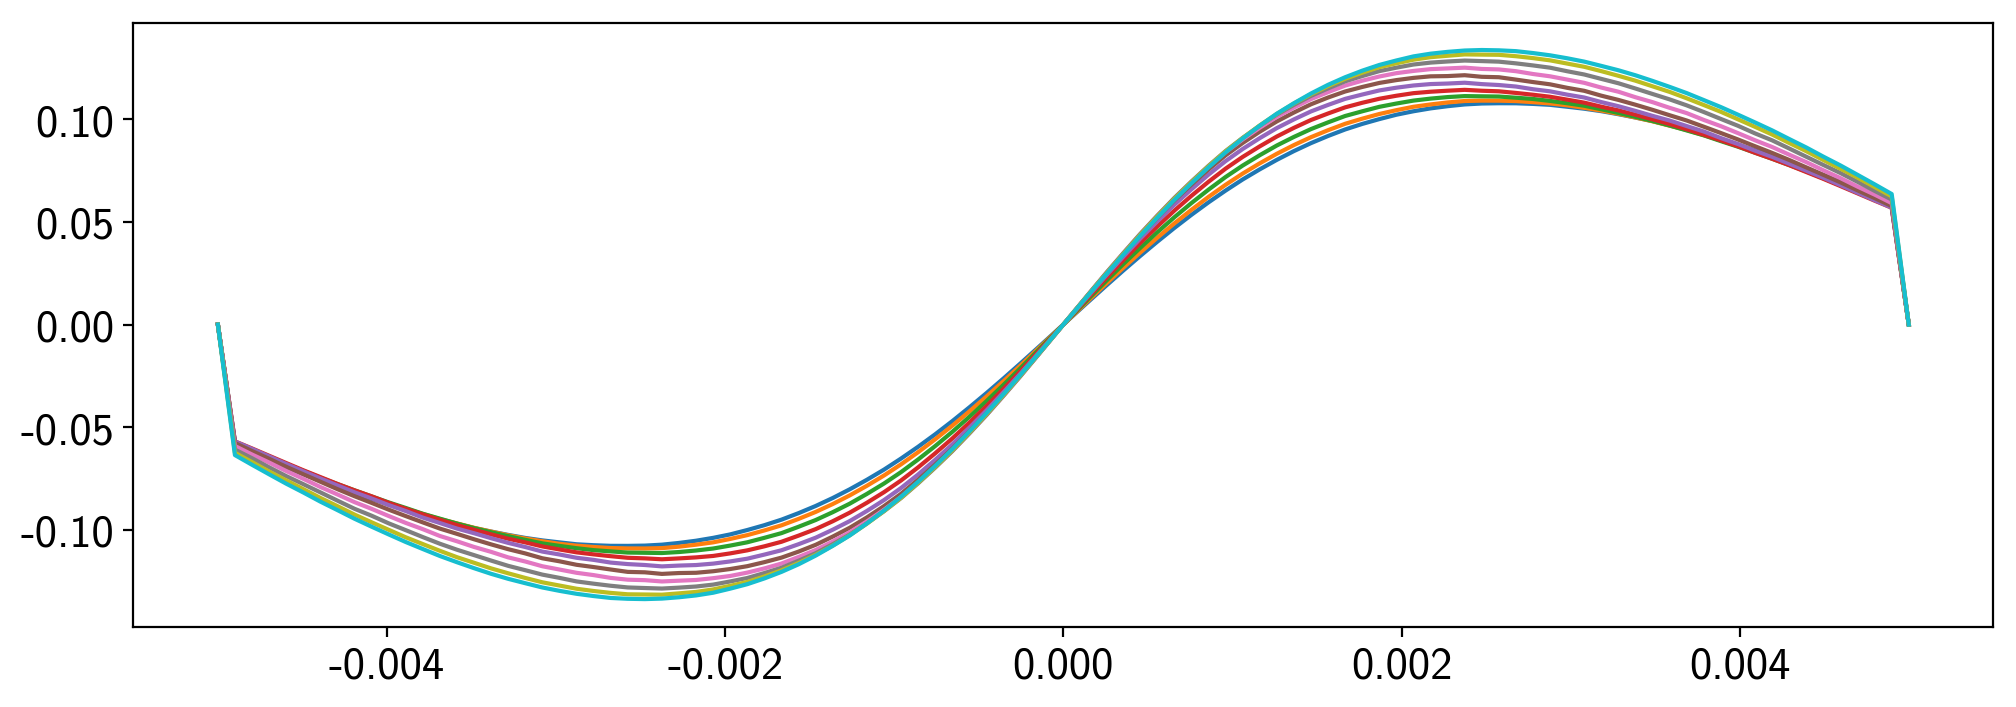

In [275]:
alpha = 0.5
for i in np.linspace(10, 90, 11)[:-1]:
    g_num = compute_numerical(tau * np.sin(i * np.pi / 180), w=w, i=i, alpha=alpha, cb=cb, nxy=nxy)
    plt.plot(tau, g_num);